In [1]:
# type: ignore
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
train_dir = 'tomato_dataset/train'
val_dir = 'tomato_dataset/val'
test_dir = 'tomato_dataset/test'

In [3]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical'
)

class_labels = list(train_generator.class_indices.keys())


Found 15973 images belonging to 10 classes.
Found 10802 images belonging to 10 classes.
Found 6570 images belonging to 10 classes.


In [4]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze base model layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('models/resnet50_tomato.keras', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1155s 2s/step - accuracy: 0.2128 - loss: 2.1894 - val_accuracy: 0.2753 - val_loss: 2.0258
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1150s 2s/step - accuracy: 0.2845 - loss: 2.0073 - val_accuracy: 0.3290 - val_loss: 1.9475
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1219s 2s/step - accuracy: 0.3106 - loss: 1.9421 - val_accuracy: 0.3352 - val_loss: 1.8849
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1245s 2s/step - accuracy: 0.3431 - loss: 1.8847 - val_accuracy: 0.4035 - val_loss: 1.8286
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1238s 2s/step - accuracy: 0.3700 - loss: 1.8334 - val_accuracy: 0.4267 - val_loss: 1.7786
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1230s 2s/step - accuracy: 0.3928 - loss: 1.7850 - val_accuracy: 0.4375 - val_loss: 1.7278
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1234s 2s/step - accuracy: 0.4064 - loss: 1.7351 - val_accuracy: 0.4577 - val_loss: 1.6827
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1239s 2s/step - accuracy: 0.4215 - loss: 1.6905 - 

In [7]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.4997 - loss: 1.5499
Test Accuracy: 49.97%


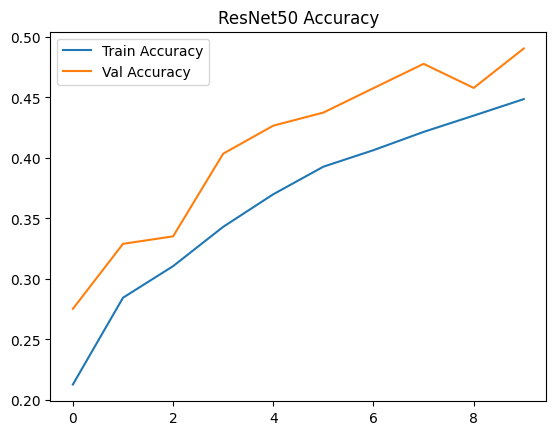

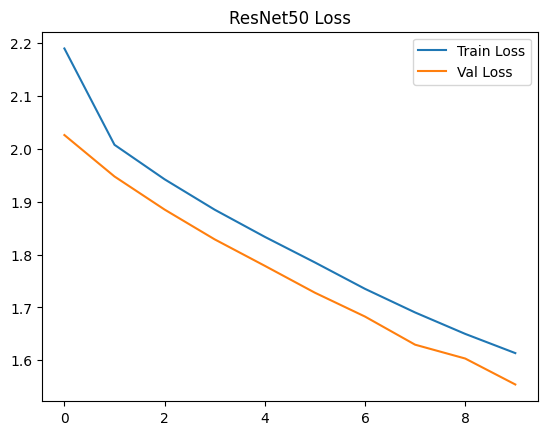

In [8]:
#accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('ResNet50 Accuracy')
plt.show()

#loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('ResNet50 Loss')
plt.show()